Clean and Sample Dataset

In [ ]:
import pandas as pd
import numpy as np
import re

# Load MovieLens files
movies = pd.read_csv("/content/movies.csv")
ratings = pd.read_csv("/content/ratings.csv")
tags = pd.read_csv("/content/tags.csv")


# Clean titles and extract year
def extract_year(title):
    match = re.search(r"\((\d{4})\)$", title)
    return int(match.group(1)) if match else np.nan

def clean_title(title):
    return re.sub(r"\(\d{4}\)$", "", title).strip()

movies["release_year"] = movies["title"].apply(extract_year)
movies["clean_title"] = movies["title"].apply(clean_title)


# Convert rating timestamp to year
ratings["rating_datetime"] = pd.to_datetime(ratings["timestamp"], unit='s')
ratings["rating_year"] = ratings["rating_datetime"].dt.year


#Reduce tags to one per movie
tag_counts = tags.groupby(["movieId", "tag"]).size().reset_index(name="count")

one_tag_per_movie = tag_counts.sort_values(["movieId", "count"], ascending=[True, False])
one_tag_per_movie = one_tag_per_movie.groupby("movieId").first().reset_index()

one_tag_per_movie = one_tag_per_movie[["movieId", "tag"]]


# Merge ratings and movies
merged = ratings.merge(movies, on="movieId", how="left")


# Merge one tag and movie
merged = merged.merge(one_tag_per_movie, on="movieId", how="left")


# Final clean dataset
final_df = merged[[
    "userId",
    "movieId",
    "rating",
    "rating_year",
    "clean_title",
    "release_year",
    "genres",
    "tag"
]]

print("Final dataset shape:", final_df.shape)
final_df.head()

final_df.to_csv("/content/final_dataset.csv", index=False)
print("Saved final_dataset.csv")


Final dataset shape: (25000095, 8)
Saved final_dataset.csv


In [ ]:
import pandas as pd

df = pd.read_csv("/content/final_dataset.csv", usecols=[
    "userId", "movieId", "rating", "rating_year",
    "clean_title", "release_year", "genres", "tag"
])

print("Full shape:", df.shape)

# Random sample of 20,000 rows
sample_df = df.sample(n=20000, random_state=42)

# Save sample
sample_df.to_csv("/content/sample_20k.csv", index=False)

print("Saved sample_20k.csv")
print(sample_df.shape)


Full shape: (25000095, 8)
Saved sample_20k.csv
(20000, 8)


Discretize Rating

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load sample
df = pd.read_csv("/content/sample_20k.csv")
print("Sample shape:", df.shape)
df.head()

# Discretize rating (Low / Medium / High)
def discretize_rating(r):
    if r <= 2.5:
        return "Low"
    elif r <= 3.5:
        return "Medium"
    else:
        return "High"

df["rating_class"] = df["rating"].apply(discretize_rating)
print(df["rating_class"].value_counts())


# One-hot encode genres
df_genres = df["genres"].str.get_dummies(sep="|")
print("Genre columns:", df_genres.shape[1])


# Label-encode tags
tag_encoder = LabelEncoder()
df["tag_encoded"] = tag_encoder.fit_transform(df["tag"].astype(str))


# Normalize numeric features
scaler = MinMaxScaler()
df_numeric = pd.DataFrame(
    scaler.fit_transform(df[["release_year", "rating_year"]]),
    columns=["release_year_scaled", "rating_year_scaled"]
)


# Build final features matrix
X = pd.concat([df_genres, df_numeric, df["tag_encoded"]], axis=1)
y = df["rating_class"]

print("Final X shape:", X.shape)
print("Target distribution:")
print(y.value_counts())


preprocessed_df = pd.concat([X, y], axis=1)
preprocessed_df.to_csv("/content/preprocessed_20k.csv", index=False)

print("Saved preprocessed_20k.csv!")


Sample shape: (20000, 8)
rating_class
High      10040
Medium     6383
Low        3577
Name: count, dtype: int64
Genre columns: 20
Final X shape: (20000, 23)
Target distribution:
rating_class
High      10040
Medium     6383
Low        3577
Name: count, dtype: int64
Saved preprocessed_20k.csv!


In [ ]:
#Clean NaN values

# Fill numeric NaNs with column median
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Fill encoded tag NaNs with a placeholder
if "tag_encoded" in X.columns:
    X["tag_encoded"] = X["tag_encoded"].fillna(-1)

# Fill genre NaNs with 0
genre_cols = [c for c in X.columns if c not in ["release_year_scaled", "rating_year_scaled", "tag_encoded"]]
X[genre_cols] = X[genre_cols].fillna(0)

print("Remaining NaNs:", X.isna().sum().sum())


Remaining NaNs: 0


PCA

Remaining NaNs: 0

Explained variance ratio:
PC1: 0.1150
PC2: 0.1006
PC3: 0.0684
PC4: 0.0603
PC5: 0.0572
PC6: 0.0529
PC7: 0.0469
PC8: 0.0443
PC9: 0.0439
PC10: 0.0431


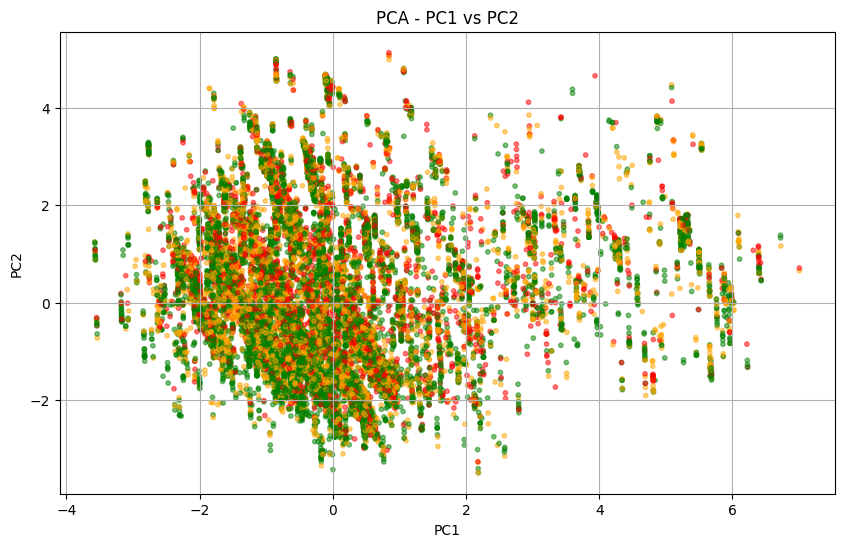

In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load preprocessed data
df = pd.read_csv("/content/preprocessed_20k.csv")

X = df.drop(columns=["rating_class"])
y = df["rating_class"]

# Fix NaN before PCA
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

if "tag_encoded" in X.columns:
    X["tag_encoded"] = X["tag_encoded"].fillna(-1)

genre_cols = [c for c in X.columns if c not in ["release_year_scaled", "rating_year_scaled", "tag_encoded"]]
X[genre_cols] = X[genre_cols].fillna(0)

print("Remaining NaNs:", X.isna().sum().sum())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)


print("\nExplained variance ratio:")
for i, ev in enumerate(pca.explained_variance_ratio_, start=1):
    print(f"PC{i}: {ev:.4f}")

plt.figure(figsize=(10,6))
colors = {"Low": "red", "Medium": "orange", "High": "green"}

plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=y.map(colors),
    s=10, alpha=0.5
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA - PC1 vs PC2")
plt.grid(True)
plt.show()


Evaluation (poor results need more work)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Load data
df = pd.read_csv("/content/preprocessed_20k.csv")

X = df.drop(columns=["rating_class"])
y = df["rating_class"]

# Make sure no more NaN
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Fill any leftover non-numeric NaN
X = X.fillna(0)


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)

# Metric function
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=["Low", "Medium", "High"])
    tn, fp, fn, tp = None, None, None, None

    print("\n-----------------------------")
    print(f" {name} Results")
    print("-----------------------------")

    print("\nConfusion Matrix (Low, Medium, High):\n", cm)
    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("Precision (macro):", precision_score(y_test, y_pred, average="macro"))
    print("Recall (macro):", recall_score(y_test, y_pred, average="macro"))
    print("F1 Score (macro):", f1_score(y_test, y_pred, average="macro"))

    return y_pred

# Decision Tree
dt = DecisionTreeClassifier(max_depth=8, random_state=42)
dt.fit(X_train, y_train)
dt_pred = evaluate_model(dt, X_test, y_test, "Decision Tree")

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_pred = evaluate_model(nb, X_test, y_test, "Naive Bayes")

# SVM
svm = SVC(kernel="rbf", C=2, gamma=0.1)
svm.fit(X_train, y_train)
svm_pred = evaluate_model(svm, X_test, y_test, "SVM")

print("\nAll models evaluated successfully.")


Training size: (16000, 23)
Testing size: (4000, 23)

-----------------------------
 Decision Tree Results
-----------------------------

Confusion Matrix (Low, Medium, High):
 [[   7  206  502]
 [   4  320  953]
 [  13  306 1689]]

Accuracy: 0.504
Precision (macro): 0.40449859724668885
Recall (macro): 0.3671709939915895
F1 Score (macro): 0.32602452585913294

-----------------------------
 Naive Bayes Results
-----------------------------

Confusion Matrix (Low, Medium, High):
 [[279 220 216]
 [358 396 523]
 [511 593 904]]

Accuracy: 0.39475
Precision (macro): 0.37359593605232905
Recall (macro): 0.3835035981644535
F1 Score (macro): 0.37110259055618866

-----------------------------
 SVM Results
-----------------------------

Confusion Matrix (Low, Medium, High):
 [[  80  207  428]
 [  85  326  866]
 [  77  320 1611]]

Accuracy: 0.50425
Precision (macro): 0.42244005107296706
Recall (macro): 0.3898215915655164
F1 Score (macro): 0.37636784415467844

All models evaluated successfully.


Optimizing dataset for better evaluation

In [ ]:
import pandas as pd

# Load data
df = pd.read_csv("/content/sample_20k.csv")

# User average rating
user_avg = df.groupby("userId")["rating"].mean().rename("user_avg_rating")
df = df.merge(user_avg, on="userId", how="left")

# User rating count
user_count = df.groupby("userId")["rating"].count().rename("user_rating_count")
df = df.merge(user_count, on="userId", how="left")

# User genre preference vector
genres_dummies = df["genres"].str.get_dummies(sep="|")

# Combine back with original df
df = pd.concat([df, genres_dummies], axis=1)

# Compute percent of each genre per user
user_genre_pref = df.groupby("userId")[genres_dummies.columns].mean()
user_genre_pref = user_genre_pref.add_prefix("user_pref_")

# Merge back
df = df.merge(user_genre_pref, on="userId", how="left")

df.to_csv("/content/sample_20k_user_features.csv", index=False)

print("Saved: sample_20k_user_features.csv")
df.head()


Saved: sample_20k_user_features.csv


,userId,movieId,rating,rating_year,clean_title,release_year,genres,tag,user_avg_rating,user_rating_count,...,user_pref_Film-Noir,user_pref_Horror,user_pref_IMAX,user_pref_Musical,user_pref_Mystery,user_pref_Romance,user_pref_Sci-Fi,user_pref_Thriller,user_pref_War,user_pref_Western
0,99476,104374,3.5,2016,About Time,2013.0,Drama|Fantasy|Romance,time travel,3.5,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0
1,107979,2634,4.0,2001,"Mummy, The",1959.0,Horror,mummy,4.5,2,...,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.000000,0.0,0.0
2,155372,1614,3.0,2004,In & Out,1997.0,Comedy,lgbt,2.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667,0.0,0.0
3,65225,7153,4.0,2008,"Lord of the Rings: The Return of the King, The",2003.0,Action|Adventure|Drama|Fantasy,fantasy,4.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,79161,500,5.0,2017,Mrs. Doubtfire,1993.0,Comedy|Drama,Robin Williams,5.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Better evaluation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Load data user feature
df = pd.read_csv("/content/sample_20k_user_features.csv")

# Discretize rating (Low / Medium / High)
def discretize_rating(r):
    if r <= 2.5:
        return "Low"
    elif r <= 3.5:
        return "Medium"
    else:
        return "High"

df["rating_class"] = df["rating"].apply(discretize_rating)

# Drop non-numeric columns not needed for model
X = df.drop(columns=[
    "rating", "rating_class", "clean_title", "genres", "tag"
])
y = df["rating_class"]

# Handle NaN values
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training size:", X_train.shape)
print("Testing size:", X_test.shape)

# Evaluation function
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred, labels=["Low", "Medium", "High"])

    print(f"\n\n===== {name} =====")
    print("Confusion Matrix:\n", cm)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average="macro"))
    print("Recall:", recall_score(y_test, y_pred, average="macro"))
    print("F1 Score:", f1_score(y_test, y_pred, average="macro"))

# Decision Tree
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_train, y_train)
evaluate_model(dt, X_test, y_test, "Decision Tree")

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, y_train)
evaluate_model(nb, X_test, y_test, "Naive Bayes")

# SVM
svm = SVC(kernel="rbf", C=2, gamma=0.1)
svm.fit(X_train, y_train)
evaluate_model(svm, X_test, y_test, "SVM")


Training size: (16000, 46)
Testing size: (4000, 46)


===== Decision Tree =====
Confusion Matrix:
 [[ 593   78   44]
 [  68 1078  131]
 [  28  114 1866]]
Accuracy: 0.88425
Precision: 0.8745814162319409
Recall: 0.867606503997354
F1 Score: 0.8709748235765072


===== Naive Bayes =====
Confusion Matrix:
 [[ 171  391  153]
 [   2  200 1075]
 [   2   79 1927]]
Accuracy: 0.5745
Precision: 0.6288089549986089
Recall: 0.4518130883344267
F1 Score: 0.4453930565178903


===== SVM =====
Confusion Matrix:
 [[   0    0  715]
 [   1    1 1275]
 [   0    0 2008]]
Accuracy: 0.50225
Precision: 0.5007503751875938
Recall: 0.3335943617854346
F1 Score: 0.22340987129719525


Item-based collaborative filtering using cosine similarity scores and user ratings

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Load data
df = pd.read_csv("/content/sample_20k.csv")
movies = pd.read_csv("/content/movies.csv")

ratings = df[["userId", "movieId", "rating"]]

# User–item matrix
ratings_matrix = ratings.pivot_table(
    index="userId",
    columns="movieId",
    values="rating"
)

# Item matrix (movies × users), fill missing with 0
item_matrix = ratings_matrix.fillna(0).T

# Train KNN model
knn = NearestNeighbors(metric="cosine", algorithm="brute")
knn.fit(item_matrix)

# Precompute similarity matrix
distances, indices = knn.kneighbors(item_matrix, n_neighbors=50)
similarity_matrix = 1 - distances


# Similar movies with similarity scores
def get_similar_movies(movie_id, top_n=10):
    if movie_id not in item_matrix.index:
        return None

    movie_idx = item_matrix.index.get_loc(movie_id)

    sim_scores = similarity_matrix[movie_idx]
    sim_indices = indices[movie_idx]

    sims = list(zip(item_matrix.index[sim_indices], sim_scores))
    sims = sims[1:top_n+1]

    df_sim = pd.DataFrame(sims, columns=["movieId", "similarity"])
    df_sim = df_sim.merge(movies, on="movieId", how="left")

    return df_sim[["movieId", "title", "similarity"]]


# Movie recommendations
def recommend_movies_for_user(user_id, top_n=10):
    if user_id not in ratings_matrix.index:
        return f"User {user_id} not found."

    user_r = ratings_matrix.loc[user_id].dropna()

    scores = {}

    for movie_i, rating in user_r.items():
        try:
            sims = get_similar_movies(movie_i, top_n=30)
        except:
            continue

        for _, row in sims.iterrows():
            movie_j = row["movieId"]
            sim = row["similarity"]

            if movie_j in user_r.index:
                continue

            scores[movie_j] = scores.get(movie_j, 0) + sim * rating

    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]

    rec_df = pd.DataFrame(sorted_scores, columns=["movieId", "score"])
    rec_df = rec_df.merge(movies, on="movieId", how="left")

    return rec_df[["movieId", "title", "score"]]


# Example recommendation
valid_user = ratings_matrix.index[0]
recommend_movies_for_user(valid_user, top_n=10)


,movieId,title,score
0,142997,Hotel Transylvania 2 (2015),0.591916
1,112290,Boyhood (2014),0.437973
2,4878,Donnie Darko (2001),0.405987
3,3489,Hook (1991),0.316595
4,98809,"Hobbit: An Unexpected Journey, The (2012)",0.311521
5,1777,"Wedding Singer, The (1998)",0.295382
6,200322,The Hustle (2019),0.000000
7,200306,Booksmart (2019),0.000000
8,199910,The Professor and the Madman (2019),0.000000
9,198153,The Beach Bum (2019),0.000000


In [ ]:
import pandas as pd

df = pd.read_csv("/content/preprocessed_20k.csv")
df.columns


Index(['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western', 'release_year_scaled', 'rating_year_scaled',
       'tag_encoded', 'rating_class'],
      dtype='object')

K-Means and Cluster centroids

Feature matrix shape: (20000, 23)


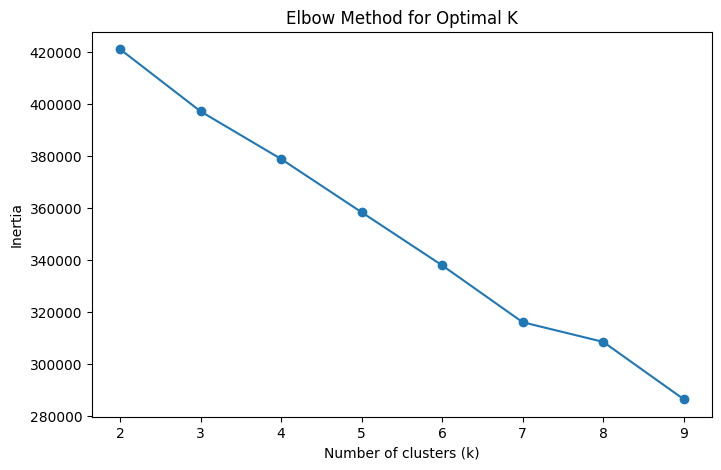

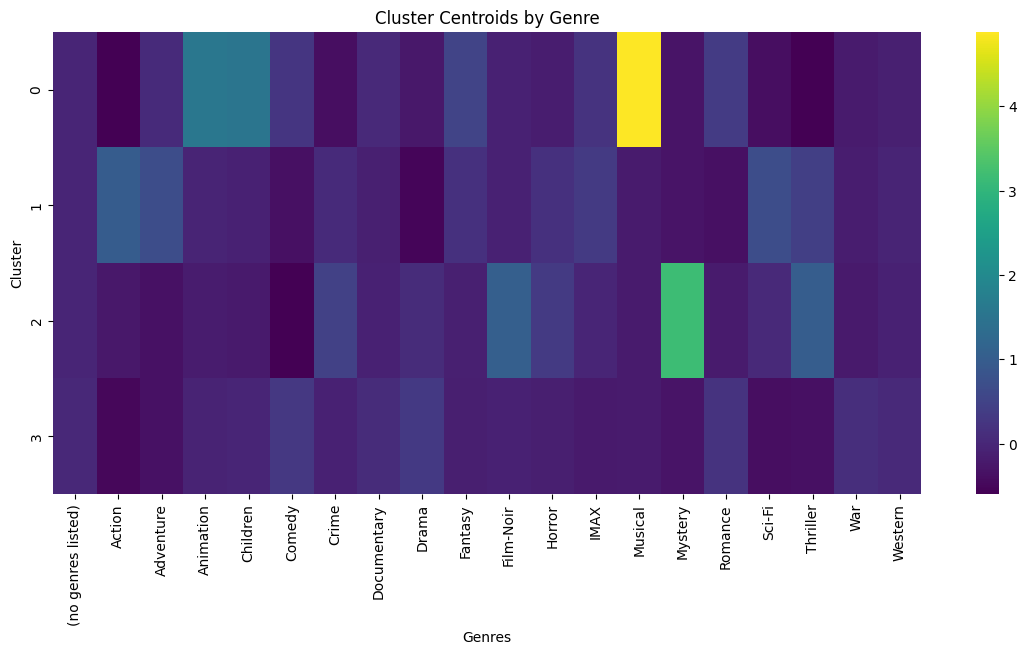

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,release_year_scaled,rating_year_scaled,tag_encoded
0,-0.028296,-0.587569,0.058199,1.575909,1.535622,0.243377,-0.392873,0.048954,-0.229010,0.505955,...,4.883106,-0.294546,0.369446,-0.389809,-0.586204,-0.186084,-0.103936,-0.864075,-0.252334,-0.352567
1,-0.028296,0.983456,0.671936,-0.048840,-0.088478,-0.374243,0.063108,-0.110440,-0.526542,0.170278,...,-0.204788,-0.296836,-0.361513,0.684938,0.423124,-0.146116,-0.039622,0.213653,0.156711,0.233823
2,-0.028296,-0.249009,-0.345671,-0.184591,-0.225588,-0.592252,0.456732,-0.089138,0.080995,-0.103790,...,-0.204788,3.165892,-0.206012,0.042766,0.990769,-0.215465,-0.080895,-0.105940,0.053092,0.240709
3,0.023362,-0.502932,-0.349822,-0.057739,-0.024751,0.297858,-0.080435,0.076126,0.317434,-0.122201,...,-0.204788,-0.299071,0.220342,-0.385661,-0.364360,0.134472,0.043924,-0.047002,-0.083053,-0.151049


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("/content/preprocessed_20k.csv")

# Clustering features
genre_cols = [
    '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
    'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
    'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

numeric_cols = ['release_year_scaled', 'rating_year_scaled', 'tag_encoded']

features = df[genre_cols + numeric_cols]

print("Feature matrix shape:", features.shape)

# Fix missing values
features = features.fillna(features.mean())

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Elbow method for k selection
inertia = []
K = range(2, 10)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(features_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()

# K-means model
k_final = 4
kmeans = KMeans(n_clusters=k_final, random_state=42)
df['cluster'] = kmeans.fit_predict(features_scaled)

# Cluster centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=genre_cols + numeric_cols)

plt.figure(figsize=(14,6))
sns.heatmap(centroids.iloc[:, :20], cmap="viridis")
plt.title("Cluster Centroids by Genre")
plt.xlabel("Genres")
plt.ylabel("Cluster")
plt.show()

centroids


In [ ]:
!pip install mlxtend


Apriori

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Load genre data (already one-hot encoded)
df = pd.read_csv("/content/preprocessed_20k.csv")

genre_cols = [
    '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
    'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
    'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
    'Thriller', 'War', 'Western'
]

genre_df = df[genre_cols].astype(int)

print("Genre matrix shape:", genre_df.shape)

# Apply Apriori
frequent_itemsets = apriori(
    genre_df,
    min_support=0.02,
    use_colnames=True
)

print("Frequent itemsets found:", frequent_itemsets.shape)
frequent_itemsets.head()

# Generate association rule
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.1
)

# Sort by highest lift (strongest rules)
rules = rules.sort_values(by="lift", ascending=False)

rules.head(10)


Genre matrix shape: (20000, 20)


/usr/local/lib/python3.12/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: Dep

Frequent itemsets found: (81, 2)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
175,"(Adventure, Children)","(Animation, Comedy)",0.05075,0.03865,0.02555,0.503448,13.025829,1.0,0.023589,1.936052,0.972588,0.400157,0.483485,0.582255
178,"(Animation, Comedy)","(Adventure, Children)",0.03865,0.05075,0.02555,0.661061,13.025829,1.0,0.023589,2.800650,0.960347,0.400157,0.642940,0.582255
181,(Animation),"(Adventure, Children, Comedy)",0.06965,0.03030,0.02555,0.366834,12.106738,1.0,0.023440,1.531510,0.986082,0.343414,0.347050,0.605034
172,"(Adventure, Children, Comedy)",(Animation),0.03030,0.06965,0.02555,0.843234,12.106738,1.0,0.023440,5.934654,0.946067,0.343414,0.831498,0.605034
174,"(Adventure, Animation)","(Children, Comedy)",0.04330,0.04945,0.02555,0.590069,11.932645,1.0,0.023409,2.318806,0.957663,0.380208,0.568744,0.553376
179,"(Children, Comedy)","(Adventure, Animation)",0.04945,0.04330,0.02555,0.516684,11.932645,1.0,0.023409,1.979448,0.963859,0.380208,0.494809,0.553376
182,(Children),"(Adventure, Animation, Comedy)",0.08760,0.02795,0.02555,0.291667,10.435301,1.0,0.023102,1.372306,0.990981,0.283889,0.271299,0.602900
171,"(Adventure, Animation, Comedy)",(Children),0.02795,0.08760,0.02555,0.914132,10.435301,1.0,0.023102,10.625658,0.930170,0.283889,0.905888,0.602900
95,"(Adventure, Children)",(Animation),0.05075,0.06965,0.03615,0.712315,10.227068,1.0,0.032615,3.233922,0.950456,0.429080,0.690778,0.615669
98,(Animation),"(Adventure, Children)",0.06965,0.05075,0.03615,0.519024,10.227068,1.0,0.032615,1.973590,0.969764,0.429080,0.493309,0.615669


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
